# Leaky Integrate and Fire (LIF) Tutorial
__Authors:__ Antoine de Comite and Florence Blondiaux

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy

---
## Tutorial Objectives
 In this tutorial, we will build up a leaky integrate-and-fire (LIF) neuron model and study its dynamics in response to various types of inputs. In particular, we are going to write a few lines of code to:  

- simulate the LIF neuron model

- drive the LIF neuron with external inputs, such as direct currents, Gaussian white noise, sinusoidal currents, ...
- study how different inputs affect the  LIF neuron's output (firing rate and spike time irregularity)

Here, we will especially emphasize identifying conditions (input statistics) under which a neuron can spike at low firing rates and in an irregular manner. The reason for focusing on this is that in most cases, neocortical neurons spike in an irregular manner.

---
## Reminder

A *membrane equation* and a *reset condition* define our *leaky-integrate-and-fire (LIF)* neuron:


\begin{equation*}
\tau_m \frac{du}{dt} = -(u(t)-u_{rest}) +RI(t)  \;\;\; if \; u(t)\leq \theta
\end{equation*}
\begin{equation*}
u(t) = u_{reset}  \;\;\;\;\;\;\;\;\;  otherwise
\end{equation*}


The membrane equation is an *ordinary differential equation (ODE)* that describes the time evolution of membrane potential $u(t)$ in response to synaptic input and leaking of change across the cell membrane. To find an approximation of the solution of this ODE, you can use explicit Euler integration over one time step.
Euler integration :
\begin{equation*}
\frac{dX(t)}{dt} \simeq \frac{X(t+\Delta t) - X(t)}{\Delta t}
\end{equation*}

In [1]:
#Useful libraries
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

## Synaptic input

![synaptic input](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/synaptic_input.png)

We start with a sinusoidal model to simulate the synaptic input $I(t)$ given by:
\begin{align*}
\\
I(t)=I_{mean}\left(1+\sin\left(\frac{2 \pi}{0.01}\,t\right)\right)\\
\\
\end{align*}

### Exercice 1
Compute the values of synaptic input $I(t)$ 

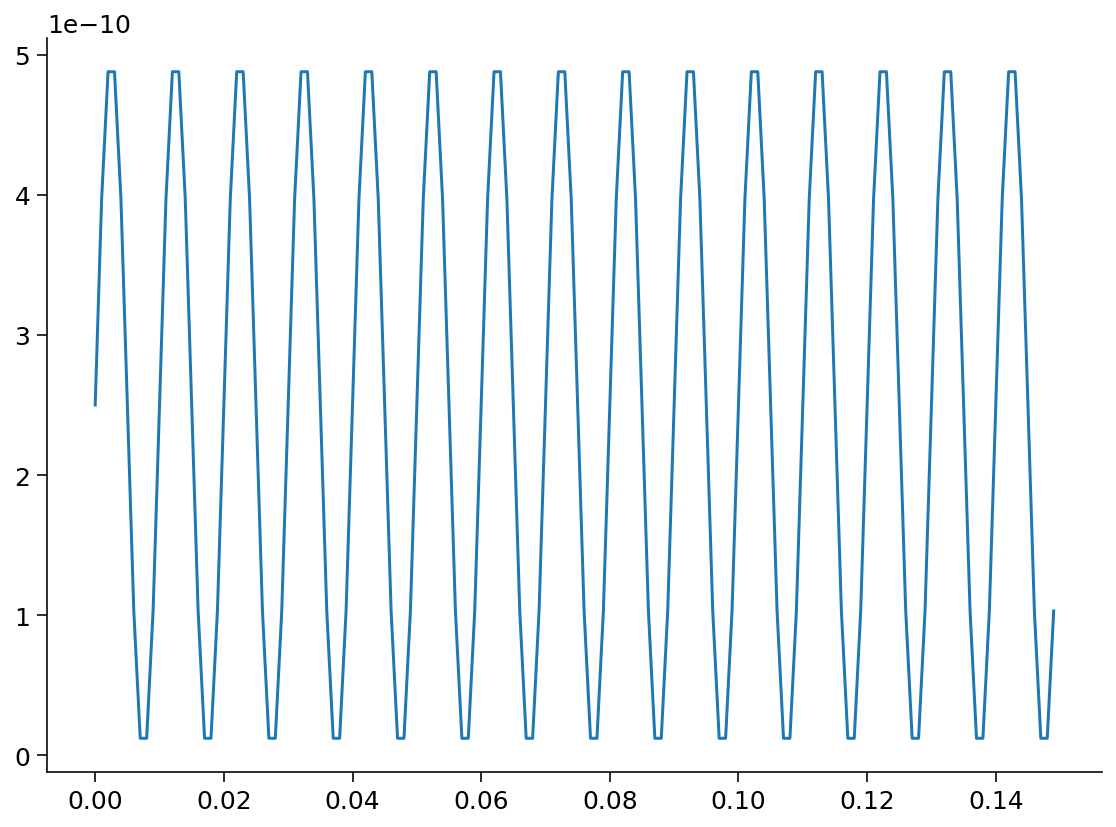

In [3]:
def syn_in(t, imean = 25e-11):
    return imean * (1 + np.sin((t * 2 * np.pi) / 0.01))

t_max = 150e-3   # second
dt = 1e-3        # second
t_range = np.arange(0,t_max, dt)

plt.plot(t_range,syn_in(t_range))
    

---
## ODE integration without spikes
In the next exercise, we now simulate the evolution of the membrane equation in discrete time steps, with a sufficiently small $\Delta t$.

We start by writing the time derivative $d/dt\,u(t)$ in the membrane equation without taking the limit $\Delta t \to 0$:

\begin{align*}
\\
\tau_m\,\frac{u\left(t+\Delta t\right)-u\left(t\right)}{\Delta t} &= -(u(t) -u_{rest} ) + R\,I(t) \qquad\qquad (1)\\
\\
\end{align*}

The value of membrane potential $u\left(t+\Delta t\right)$ can be expressed in terms of its previous value $u(t)$ by simple algebraic manipulation. For *small enough* values of $\Delta t$, this provides a good approximation of the continuous-time integration.

This operation is an integration since we obtain a sequence $\{u(t), u(t+\Delta t), u(t+2\Delta t),...\}$ starting from the ODE. Notice how the ODE describes the evolution of $\frac{d}{dt}\,u(t)$, the derivative of $u(t)$, but not directly the evolution of $u(t)$. For the evolution of $u(t)$ we need to integrate the ODE, and in this tutorial, we will do a discrete-time integration using the Euler method. See [Numerical methods for ordinary differential equations](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) for additional details.

### Exercice 2 
Implement the evolution of the membrane potential in response to an input_current

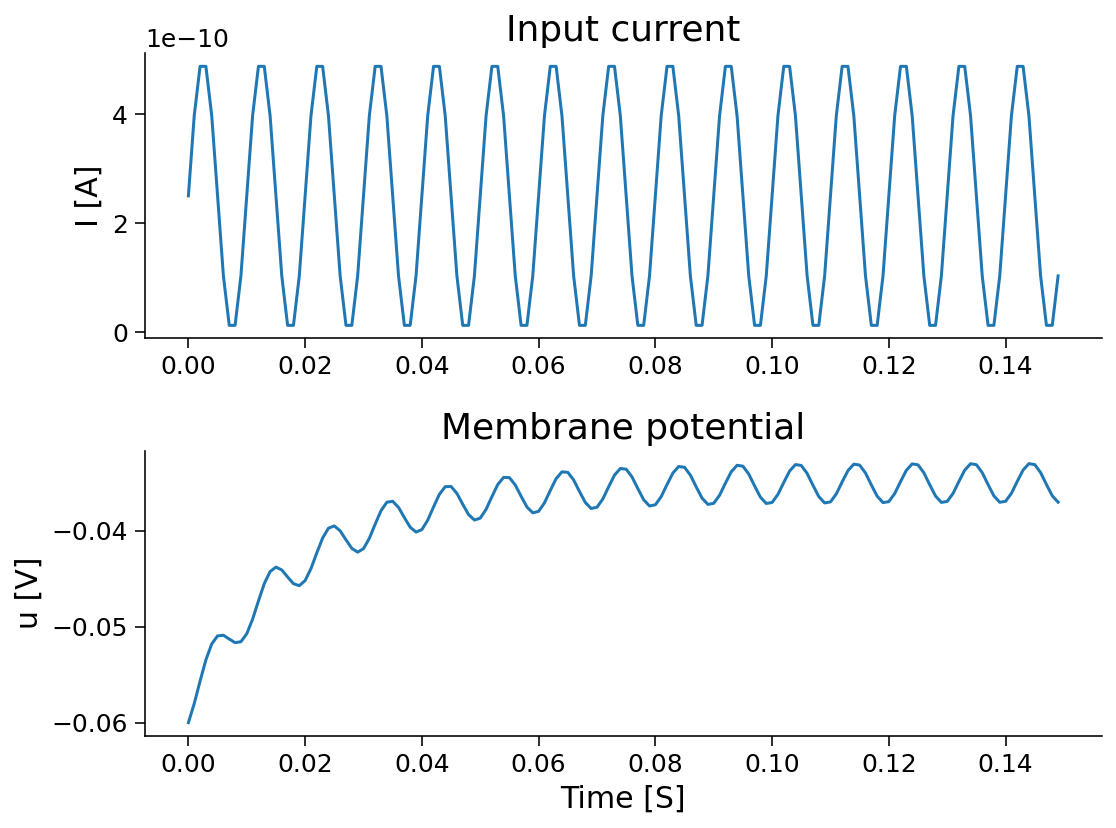

In [32]:
def membranePot(input_current, t, tau= 20e-3 , urest= -60e-3 , r= 100e6): #TODO Add a description of function and remove content.
    dt = t[1]-t[0]
    u = np.zeros(len(input_current))
    u[0]=urest
    for step in range(0,len(input_current)-1):
        u[step+1]=u[step] + dt/tau * ( -u[step] + urest +r* input_current[step+1])
    return u

#Generates a random input current
t_max = 150e-3   # second
dt = 1e-3        # second
t_range = np.arange(0,t_max,dt)
input_current = syn_in(t_range)
u = membranePot(input_current, t_range)

fig, axs = plt.subplots(2)
axs[0].plot(t_range,input_current)
axs[0].set(title = "Input current", ylabel = "I [A]")
axs[1].plot(t_range,u)
axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
plt.show()

---
# Introduce spikes
A spike takes place whenever $u(t)$ crosses $\theta$. In that case, a spike is recorded and $u(t)$ resets to $u_{reset}$ value. This is summarized in the *reset condition*:
$$u(t) = u_{reset}\quad \text{ if } u(t)\geq \theta$$

For more information about spikes or action potentials see [here](https://en.wikipedia.org/wiki/Action_potential) and [here](https://www.khanacademy.org/test-prep/mcat/organ-systems/neuron-membrane-potentials/a/neuron-action-potentials-the-creation-of-a-brain-signal).


![spikes cartoon](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/spikes_carton.png)

### Exercice 3 
Add the spiking process to your LIF model

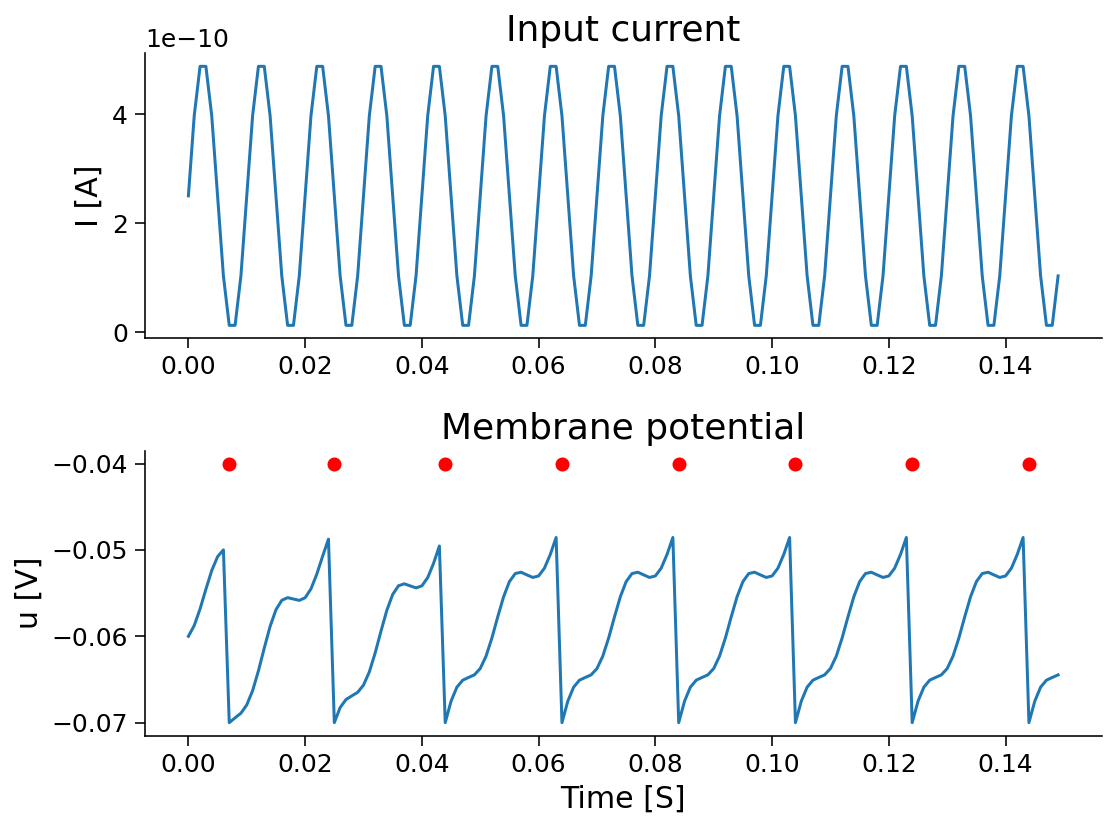

In [6]:
""" Implements a simplifed version of the LIF model, integrates the current in input following equation (1) and 
fire when the threshold reaches theta.

Input :  input_current: a vector containing the input current [A]
         step_end: the number of timestep 
         tau
         urest:  Potential of the membrane at rest [V]
         r
         ureset : Potential of the membrane after a spike
         theta: the threshold 
Output: u: the membrane potential at each time step
Output: ts: the timing at which the neurone spiked
"""
def simple_LIF(input_current,t,  tau= 20e-3 , urest= -60e-3 , r= 100e6, ureset = -70e-3 \
               ,theta = -50e-3 ): #TODO Add a description of function and remove content.
    ts = []
    dt = t[1]-t[0]
    u = np.zeros(len(input_current))
    u[0]=urest
    for step in range(0,len(input_current)-1):
        if u[step] > theta:
            u[step+1] = ureset
            ts.append((step+1)*dt)
        else:
            u[step+1]=u[step] -dt/tau * (u[step]-urest) + r*dt/tau * input_current[step]
    return u, ts

t_max = 150e-3   # second
dt = 1e-3        # second
t_range = np.arange(0,t_max,dt)
input_current = syn_in(t_range)
u ,ts = simple_LIF(input_current, t_range)

fig, axs = plt.subplots(2)
axs[0].plot(t_range,input_current)
axs[0].set(title = "Input current", ylabel = "I [A]")
axs[1].plot(t_range,u)
axs[1].plot(ts,np.ones(len(ts))*-40e-3,'r.',markersize=12)
axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
plt.show()


---
# Refractory period

The absolute refractory period is a time interval in the order of a few milliseconds during which synaptic input will not lead to a 2nd spike, no matter how strong. This effect is due to the biophysics of the neuron membrane channels, and you can read more about absolute and relative refractory period [here](https://content.byui.edu/file/a236934c-3c60-4fe9-90aa-d343b3e3a640/1/module5/readings/refractory_periods.html) and [here](https://en.wikipedia.org/wiki/Refractory_period_(physiology)).

![refractory period plot](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/refractory_period.png)

### Exercise 4 
Add the refractory period to your model

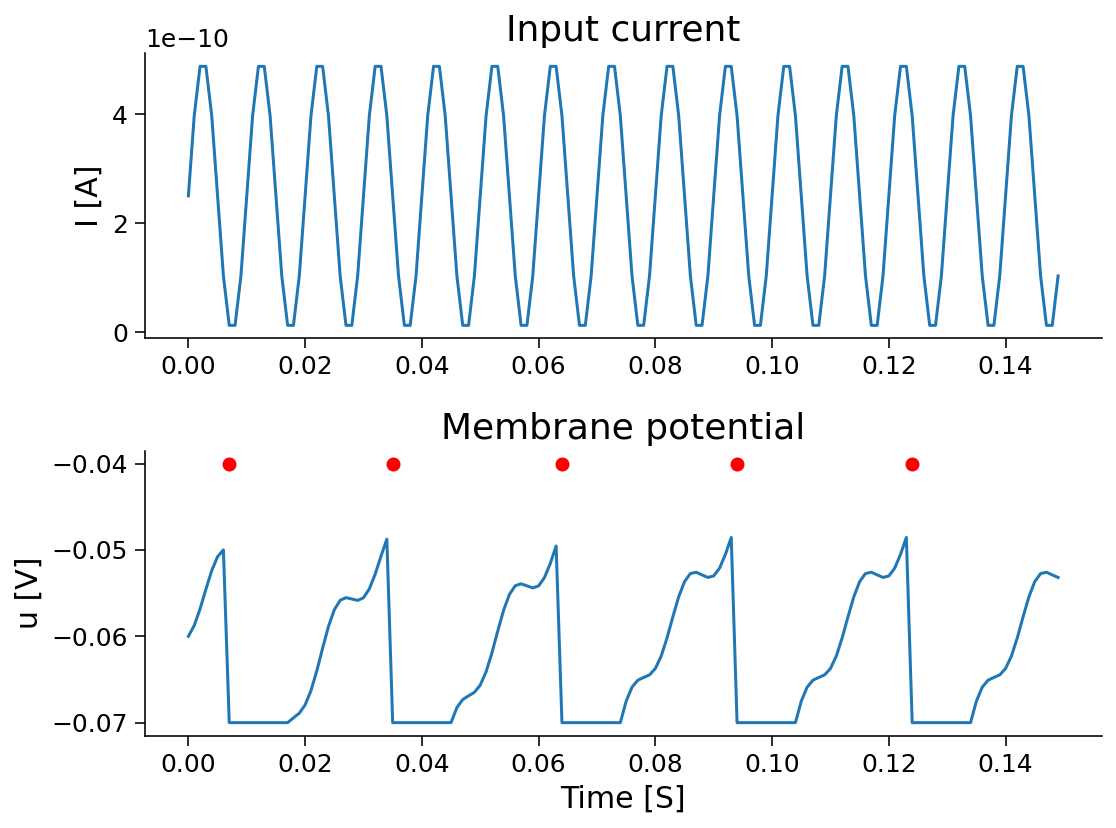

In [34]:
""" Implements the LIF model, integrates the current in input following equation (1) and 
fire when the threshold reaches theta.

Input :  input_current: a vector containing the input current [A]
         step_end: the number of timestep 
         tau
         urest:  Potential of the membrane at rest [V]
         r
         ureset : Potential of the membrane after a spike
         theta: the threshold 
Output: u: the membrane potential at each time step
        ts:
"""
def LIF(input_current,t,  tau= 20e-3 , urest= -60e-3 , r= 100e6, ureset = -70e-3 \
               ,theta = -50e-3, t_ref = 10e-3 ): #TODO Add a description of function and remove content.
    u = np.zeros_like(input_current)
    ts = []
    dt = t[1]-t[0]
    S = np.zeros_like(input_current)
    u[0]=urest
    t_wait = 0
    for step in range(0,len(input_current)-1):
        if u[step] > theta:
            u[step+1] = ureset
            t_wait = t_ref/dt
            ts.append((step+1)*dt)
            S[step+1] = 1
        elif t_wait >0:
            u[step +1] = ureset
            t_wait -=1
        else:
            u[step+1]=u[step] -dt/tau * (u[step]-urest) + r*dt/tau * input_current[step]
    return u, ts, S

t_max = 150e-3   # second
dt = 1e-3        # second
t_range = np.arange(0,t_max,dt)
input_current = syn_in(t_range)
u,ts, S = LIF(input_current, t_range)


fig, axs = plt.subplots(2)
axs[0].plot(t_range,input_current)
axs[0].set(title = "Input current", ylabel = "I [A]")
axs[1].plot(t_range,u)
axs[1].plot(ts,np.ones(len(ts))*-40e-3,'r.',markersize=12)
axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
plt.show()

### Exercice 5
Explore different values for t_ref

In [35]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    tref=widgets.FloatSlider(10e-3, min=0, max=30e-3, step=2e-3, layout=my_layout)
)

def diff_tref(tref = 10e-3):
    
    t_max = 150e-3   # second
    dt = 1e-3        # second
    t_range = np.arange(0,t_max,dt)
    input_current = syn_in(t_range)
    u,ts, S = LIF(input_current, t_range,t_ref = tref)

    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,input_current)
    axs[0].set(title = "Input current", ylabel = "I [A]")
    axs[1].plot(t_range,u)
    axs[1].plot(ts,np.ones(len(ts))*-40e-3,'r.',markersize=12)
    axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='tref', layout=Layout(width='450px'), max=0.03, step…

---
## Random synaptic input
From the perspective of neurons, synaptic input is random (or stochastic). We'll improve the synaptic input model by introducing random input current with statistical properties similar to the previous exercise:

\begin{align*}
\\
I(t)=I_{mean}\left(1+0.1\sqrt{\frac{t_{max}}{\Delta t}}\,\xi(t)\right)\qquad\text{with }\xi(t)\sim \mathcal{N}(0,\sigma)\\
\\
\end{align*}

where $\mathcal{N}(0,\sigma)$ is the [gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution).

Random synaptic input $I(t)$ results in random time course for $u(t)$.

### Exercise 6
Plot the values of $u(t)$ with random input $I(t)$.


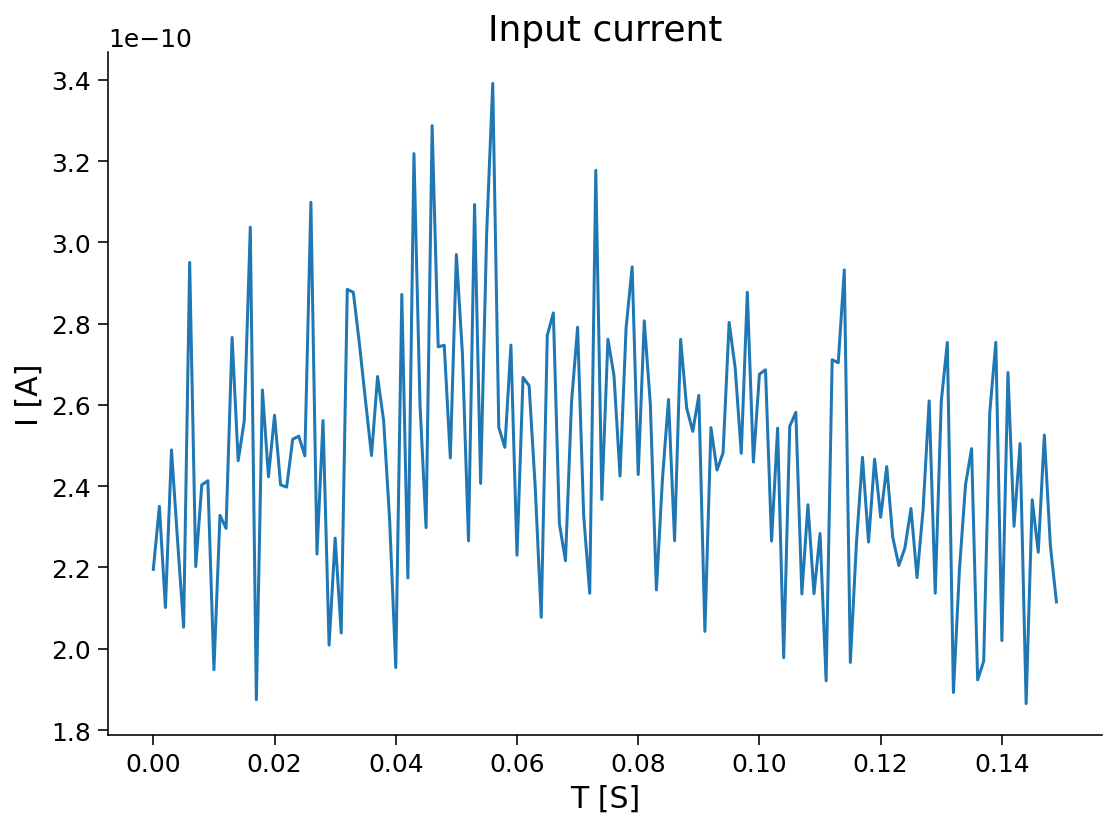

In [36]:
def rand_syn(t,sigma = 0.1, imean = 25e-11):
    dt = t[1]-t[0]
    return imean * (1 + 0.1 * (np.sqrt(np.max(t)/dt)) * np.random.normal(0,sigma,len(t)))

t_max = 150e-3   # second
dt = 1e-3        # second
t_range = np.arange(0,t_max,dt)
plt.plot(t_range,rand_syn(t_range))
plt.title('Input current')
plt.ylabel('I [A]')
plt.xlabel('T [S]')
plt.show()
    

Once you have implemented the random input current, explore the effect different values of sigma have on the membrane potential

In [37]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    sigma=widgets.FloatSlider(0.8, min=0, max=5, step=0.2, layout=my_layout)

)

def diff_DC(sigma = 0.1):
    t_max = 150e-3   # second
    dt = 1e-3        # second
    t_range = np.arange(0,t_max,dt)
    input_current = rand_syn(t_range, sigma)
    u,ts, S = LIF(input_current, t_range)
    
    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,input_current)
    axs[0].set(title = "Input current", ylabel = "I [A]")
    axs[1].plot(t_range,u)
    axs[1].plot(ts,np.ones(len(ts))*-40e-3,'r.',markersize=12)
    axs[1].set(title = "Membrane potential", ylabel = "u [V]", xlabel= "Time [S]")
    plt.show()

interactive(children=(FloatSlider(value=0.8, description='sigma', layout=Layout(width='450px'), max=5.0, step=…

---
## Raster plot

A *raster plot* represents spikes from multiple neurons by plotting dots at spike times from neuron `j` at plot height `j`, i.e. 
```
plt.scatter(spike_times, j*np.ones_like(spike_times))
```

![spikes plot](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/spikes_plot.png)

## Exercise 6
Simulate the responses of 500 neurons to a random input current and create a rasterplot to compile their answers.

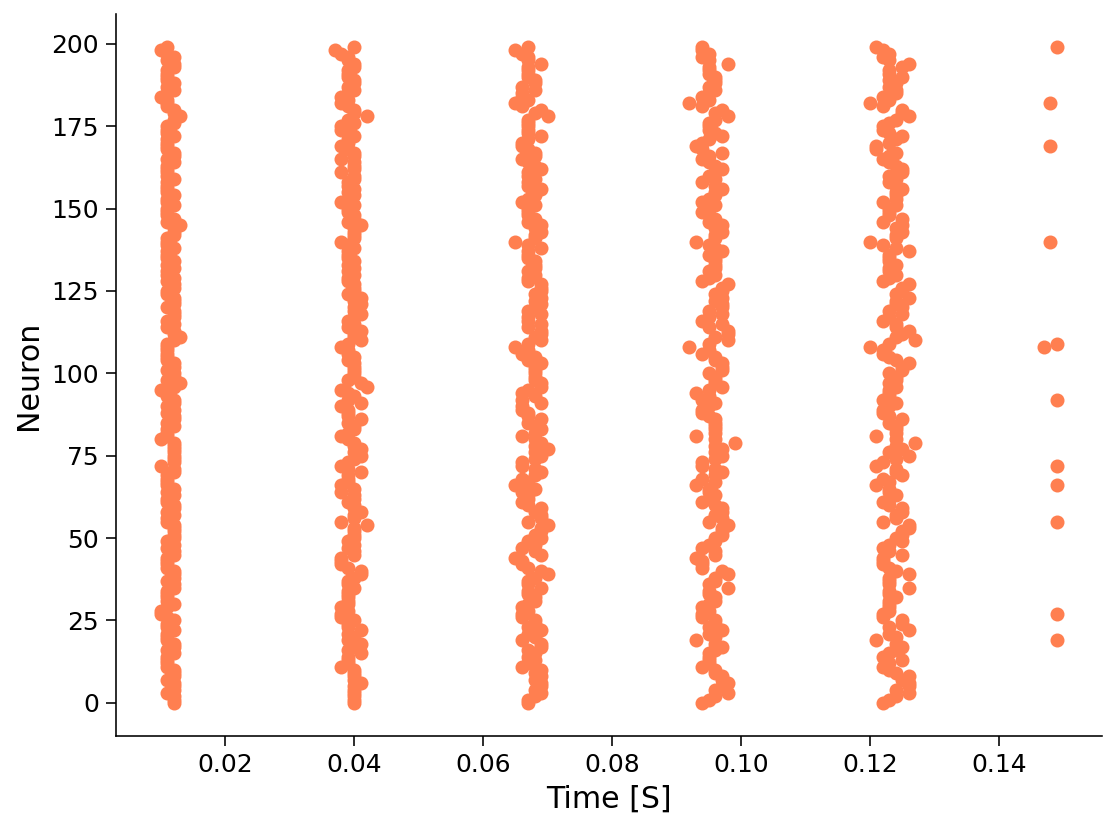

In [40]:
"""Computes the answer of N neurons to a random synaptic input
N : number of neurons
t_range : the timings we are investigating for all the neurons
sigma: Noise for the random current
"""
def make_raster_plot(N,t_range,sigma=0.1):
    dt = t_range[1]-t_range[0]
    neurons= {}
    for i in range(N):
        input_current = rand_syn(t_range,sigma)
        u,neurons[i], S = LIF(input_current, t_range)

    for i in range(N):
        spike_times = neurons[i]
        plt.scatter(spike_times, i*np.ones_like(spike_times),facecolor='coral')
    plt.xlabel('Time [S]')
    plt.ylabel('Neuron')
    plt.show()
        

t_max = 150e-3   # second
dt = 1e-3        # second
t_range = np.arange(0,t_max,dt)
make_raster_plot(200,t_range,sigma=0.1)

In [41]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    sigma=widgets.FloatSlider(0.8, min=0, max=2, step=0.5, layout=my_layout)

)

def raster_plot(sigma = 0.8):
    t_max = 150e-3   # second
    dt = 1e-3        # second
    step_end = int(t_max / dt) - 1
    t_range = np.linspace(0,dt*step_end,step_end)
    input_current = rand_syn(t_range,dt, sigma)
    
    make_raster_plot(200,t_range,sigma)


interactive(children=(FloatSlider(value=0.8, description='sigma', layout=Layout(width='450px'), max=2.0, step=…

---
## Firing rate : Reiminder 

Let ${f_i}^n_{i=1}$ represent the firing times and $S(t) := \sum_i \delta(t-t_i)$ be the spike train.

The firing rate, $p(t)$, is defined as the convolution of the spike train with a
kernel function called $\kappa(t)$: $$ \rho(t):= \kappa(t) *  S(t) = \int \kappa(t) S(t-s)ds$$

The instantaneous firing rate depends on the choice of the kernel
function !

## Exercice 7

Compute the firing rate using a rectangular kernel $ \kappa(t)= (\Delta t)^{-1} 1_{0 \leq t \leq \Delta t} $. $\rho(t)$ will therefore be the spike count in a sliding window of side $\Delta t$.

Hint: use the convolve function from numpy


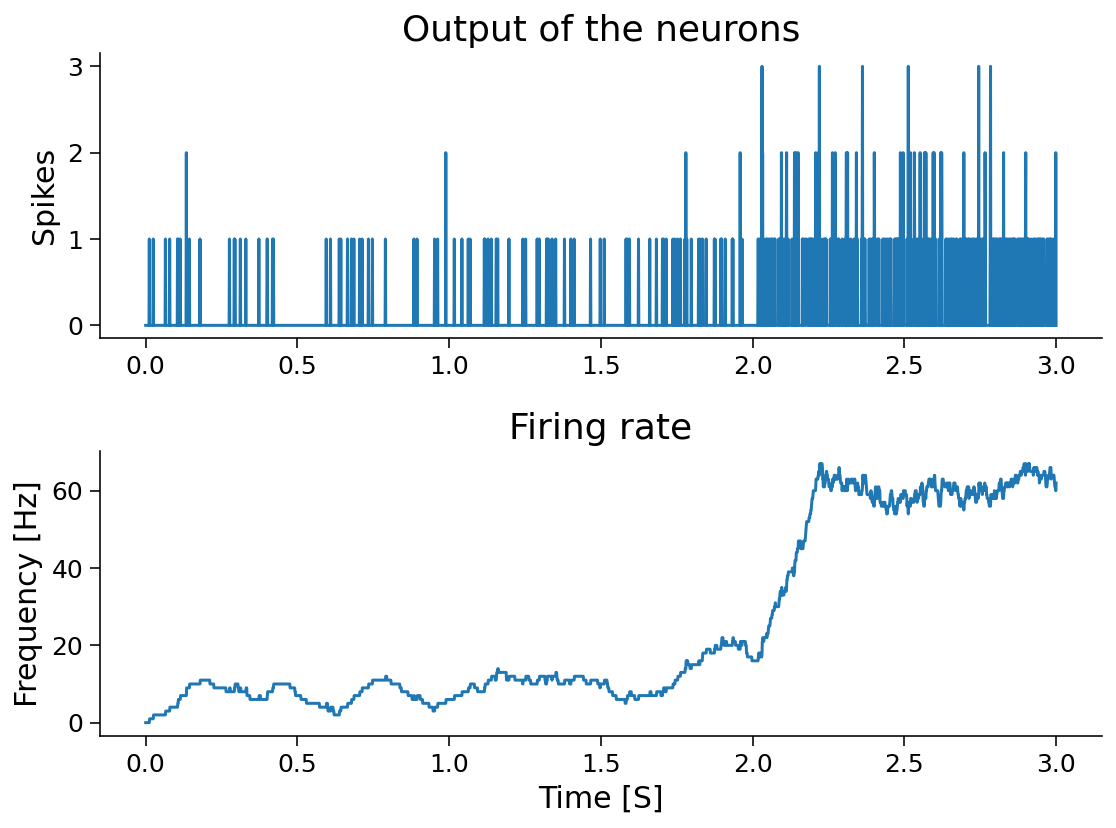

In [70]:
#Firing rate
""" 
Computes the firing rate of a neuron, needs in imput the spike train, and the kernel function. 
Output the firing rate."""
def firing_rate_rectKernel(S,dt = 1e-3, Dt = 0.2):
    k = np.zeros(len(S[0,:]))
    k[1:int(Dt/dt)] = 1 #Kernel 
    res = np.ones((10,6001)) # Il y à de manière évidente un problème quelque part, mais c'est vendredi et il est 
    # 4h, mon cerveau n'arrive plus à réfléchir --'
    for i in range(np.size(S[:,0])):
        res[i,:] = np.convolve(S[i,:], k) #A peu près sure que c'est dans les paramètres à donner à convovle : 'same, 'valid
    return np.sum(res,axis=0)
    

S = np.genfromtxt('Output_Current.csv', delimiter=',') #TO UPLOAD ON GITHUB

t_range = np.arange(0,3.001,1e-3)
fig, axs = plt.subplots(2)
axs[0].plot(t_range,np.sum(S,axis = 0))
axs[0].set(title = "Output of the neurons", ylabel = "Spikes")
axs[1].plot(t_range, firing_rate_rectKernel(S)[:3001]) #Je n'ai pas trouvé les bons paramètres pour la convolution, je suis obligée de supprimer le reste de l'output (que des 0s)
axs[1].set(title = "Firing rate", ylabel = "Frequency [Hz]", xlabel= "Time [S]")
plt.show()

In [72]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    Dt=widgets.FloatSlider(0.2, min=0, max=0.5, step=0.025, layout=my_layout)

)

def firingRate(Dt = 0.2):
        
    S = np.genfromtxt('Output_Current.csv', delimiter=',') #TO UPLOAD ON GITHUB
    t_range = np.arange(0,3.001,1e-3)
    fig, axs = plt.subplots(2)
    axs[0].plot(t_range,np.sum(S,axis = 0))
    axs[0].set(title = "Output of the neurons", ylabel = "Spikes")
    axs[1].plot(t_range, firing_rate_rectKernel(S,1e-3,Dt)[:3001])
    axs[1].set(title = "Firing rate", ylabel = "Frequency [Hz]", xlabel= "Time [S]")
    plt.show()

interactive(children=(FloatSlider(value=0.2, description='Dt', layout=Layout(width='450px'), max=0.5, step=0.0…

## ISI intervals and coefficient of variation

Spike regularity can be quantified as the **coefficient of variation (CV) of the inter-spike-interval (ISI)**:
\begin{align}
\text{CV}_{\text{ISI}} = \frac{std(\text{ISI})}{mean(\text{ISI})}
\end{align}

A Poisson train is an example of high irregularity, in which $\textbf{CV}_{\textbf{ISI}} \textbf{= 1}$. And for a clocklike (regular) process we have $\textbf{CV}_{\textbf{ISI}} \textbf{= 0}$ because of **std(ISI)=0**.

## Exercice 8
Compute the inter-spike interval distribution as well as the coefficient of variation of signals provided in S to assess the stochasticity of neuron's activity.

1.2131856039493532
1.2775574774284002
1.51851041702847
1.5556956659485315
1.36132172127516
1.2917684415526118
2.5440597678031334
1.5009508301598642
1.349498499010062
1.837965223256399


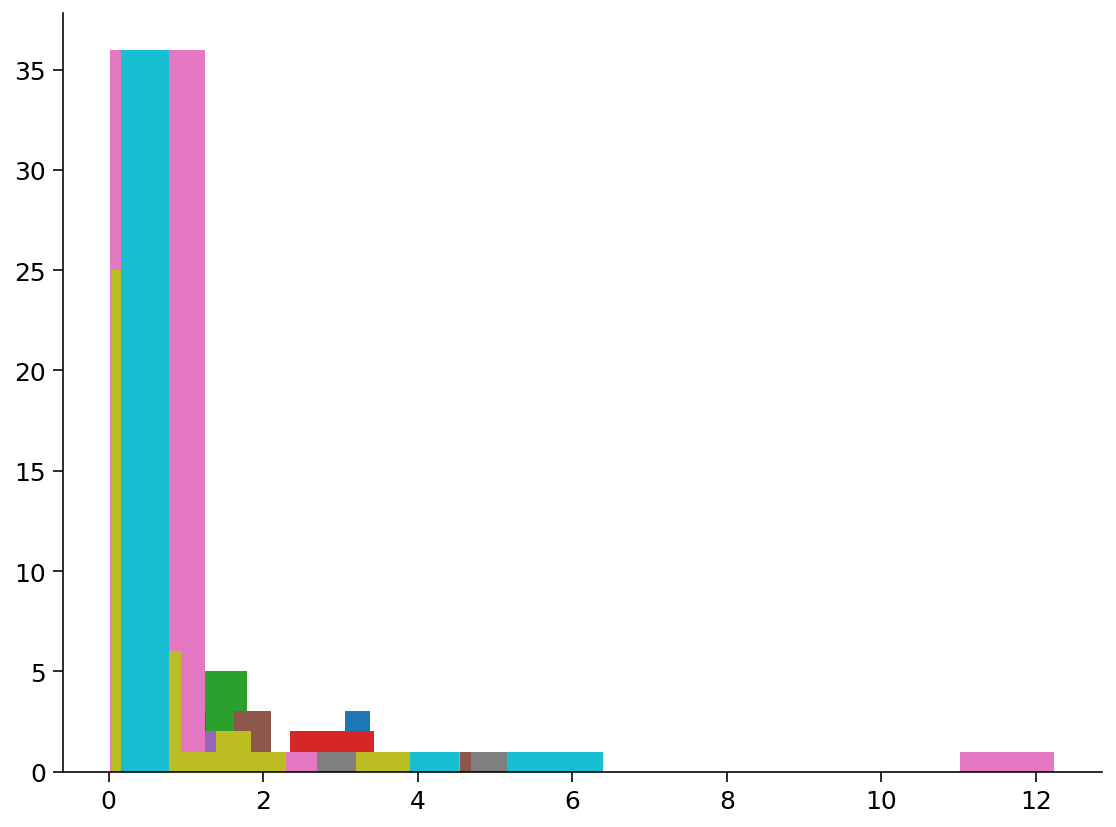

In [73]:
S = np.genfromtxt('Output_Current.csv', delimiter=',') #TO UPLOAD ON GITHUB
for i in range(len(S[:,0])):
    ISI = np.diff((np.where(S[i,:]))[0]*0.01)
    plt.hist(ISI)
    print(np.std(ISI)/np.mean(ISI))

---
# Bonus 1: Orenstein-Uhlenbeck Process

When a neuron receives spiking input, the synaptic current is Shot Noise -- which is a kind of colored noise and the spectrum of the noise determined by the synaptic kernel time constant. That is, a neuron is driven by **colored noise** and not GWN.

We can model colored noise using the Ohrenstein-Uhlenbeck process - filtered white noise. 

## Ornstein-Uhlenbeck (OU) current

We next study if the input current is temporally correlated and is modeled as an Ornstein-Uhlenbeck process $\eta(t)$, i.e., low-pass filtered GWN with a time constant $\tau_{\eta}$: 

$$\tau_\eta \frac{d}{dt}\eta(t) = \mu-\eta(t) + \sigma_\eta\sqrt{2\tau_\eta}\xi(t).$$

**Hint:** An OU process as defined above has

$$E[\eta(t)]=\mu$$ 

and autocovariance 

$$[\eta(t)\eta(t+\tau)]=\sigma_\eta^2e^{-|t-\tau|/\tau_\eta},$$

which can be used to check your code. 

In [ ]:
# @title `my_OU(pars, mu, sig, myseed)` #TODO 
# @markdown Ececute this cell to enable the OU process


def my_OU(pars, mu, sig, myseed=False):
    """
    Function that produces Ornstein-Uhlenbeck input
    Args:
        pars       : parameter dictionary
        sig        : noise amplitute
        myseed     : random seed. int or boolean

    Returns:
        I_ou       : Ornstein-Uhlenbeck input current
    """

  # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tau_ou = pars['tau_ou']  # [ms]

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Initialize
    noise = np.random.randn(Lt)
    I_ou = np.zeros(Lt)
    I_ou[0] = noise[0] * sig

    # generate OU
    for it in range(Lt-1):
        I_ou[it+1] = I_ou[it] + (dt / tau_ou) * (mu - I_ou[it]) + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1]

    return I_ou

### Interactive Demo: LIF Explorer with OU input
In the following, we will check how a neuron responds to a noisy current that follows the statistics of an OU process.

In [ ]:
# @title

# @markdown Remember to enable the widget by running the cell!

my_layout.width = '450px'
@widgets.interact(
  tau_ou=widgets.FloatSlider(10.0, min=5., max=20.,
                             step=2.5, layout=my_layout),
  sig_ou=widgets.FloatSlider(10.0, min=5., max=40.,
                             step=2.5, layout=my_layout),
  mu_ou=widgets.FloatSlider(190.0, min=180., max=220.,
                            step=2.5, layout=my_layout)
)


def LIF_with_OU(tau_ou=10., sig_ou=40., mu_ou=200.):
    pars = default_pars(T=1000.)
    pars['tau_ou'] = tau_ou  # [ms]

    I_ou = my_OU(pars, mu_ou, sig_ou)

    v, sp = run_LIF(tau = tau_ou, Iinj=I_ou)

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(pars['range_t'], I_ou, 'b', lw=1.0)
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$I_{\mathrm{OU}}$ (pA)')
    plt.subplot(122)
    plot_volt_trace(pars, v, sp)
    plt.tight_layout()
    plt.show()